# Visualización de embeddings AE a baja escala

In [1]:
import geopandas as gpd
import contextily as ctx
from shapely.geometry import box
from pyproj import Transformer
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import umap

/Users/diegolarraguibel/Desktop/Semestre 2025-2/Aprendizaje en Grafos/github_aprendizaje_grafos/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ae_emb = gpd.read_file("../data/embeddings_alpha_earth.gpkg")
ae_emb = gpd.GeoDataFrame(ae_emb, geometry=gpd.points_from_xy(ae_emb.lon, ae_emb.lat), crs="EPSG:4326")
comunas = gpd.read_file("../data/comunas_filtradas.gpkg")
comunas.to_crs(ae_emb.crs, inplace=True)

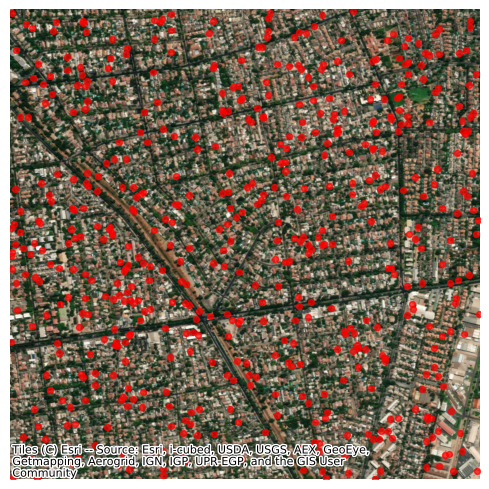

In [3]:
# --- Centro aproximado de La Reina ---
lon, lat = -70.55729, -33.44978
half_size_m = 1000

to_3857 = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)
x, y = to_3857.transform(lon, lat)

bbox = box(x - half_size_m, y - half_size_m, x + half_size_m, y + half_size_m)
gdf_bbox = gpd.GeoDataFrame(geometry=[bbox], crs="EPSG:3857")
ae_emb_3857 = ae_emb.to_crs("EPSG:3857")
ae_emb_subset = ae_emb_3857[ae_emb_3857.within(bbox)]

fig, ax = plt.subplots(figsize=(5, 5))
xmin, ymin, xmax, ymax = gdf_bbox.total_bounds
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

ctx.add_basemap(
    ax, source=ctx.providers.Esri.WorldImagery,
    zoom=17,
    crs="EPSG:3857"
)

ae_emb_subset.plot(ax=ax, markersize=18, color="red", alpha=0.7)
ax.set_axis_off()
plt.tight_layout()
plt.show()

### Visualización UMAP

In [4]:
def generate_emb_vector(df):
    features = [col for col in df.columns if col.startswith("A")]
    df['embedding'] = df.apply(lambda row: np.array(row[features]), axis=1)
    return df
ae_emb = generate_emb_vector(ae_emb)

In [6]:
x = ae_emb.geometry.x.values
y = ae_emb.geometry.y.values

emb_matrix = np.vstack(ae_emb["embedding"].values)

x_norm = (x - x.min()) / (x.max() - x.min())
y_norm = (y - y.min()) / (y.max() - y.min())

umap_model = umap.UMAP(n_components=2, n_jobs=-1, metric="cosine")
emb_umap = umap_model.fit_transform(emb_matrix)


In [5]:
# colores
c00 = np.array([0.9, 0.9, 0.9]) 
c10 = np.array([0.1, 0.6, 0.9]) 
c01 = np.array([0.9, 0.4, 0.5]) 
c11 = np.array([0.3, 0.0, 0.4])

def get_bivariate_color(x_norm, y_norm, c00, c10, c01, c11):
    """
    Calcula el color interpolando entre 4 esquinas basado en x_norm y y_norm (0-1).
    """
    x = x_norm[:, None]
    y = y_norm[:, None]
    bottom = c00 * (1 - x) + c10 * x
    top    = c01 * (1 - x) + c11 * x
    final_color = bottom * (1 - y) + top * y
    return np.clip(final_color, 0, 1)

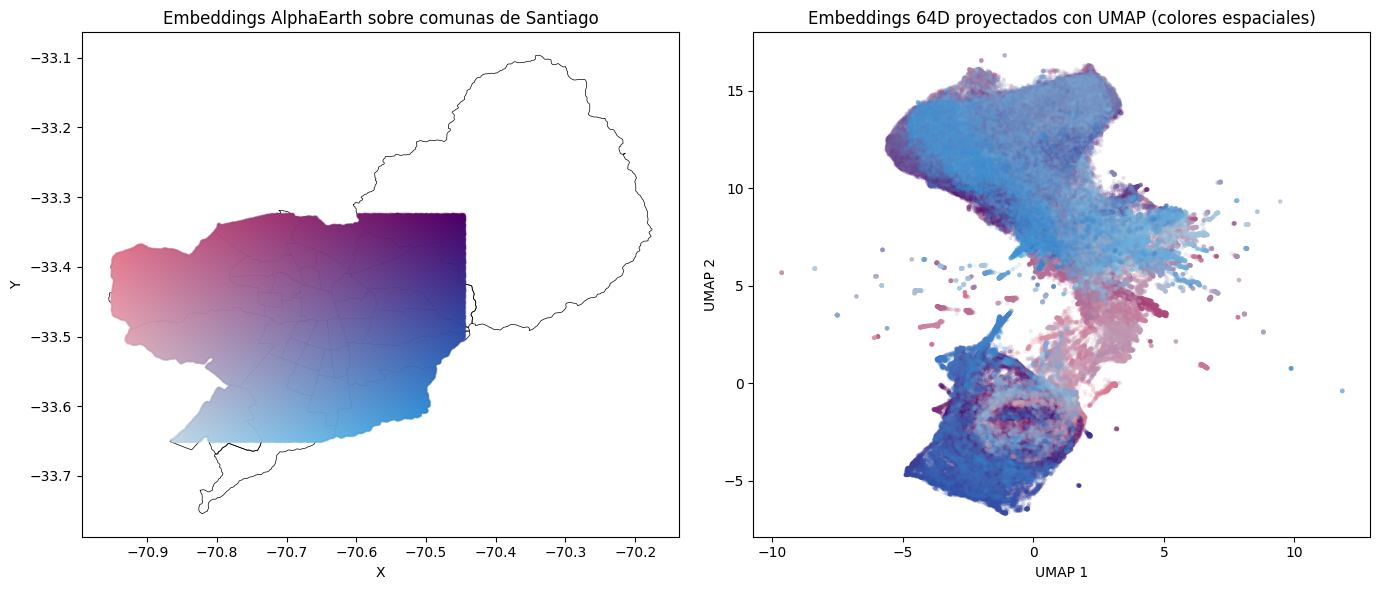

In [10]:
x_norm = (x - x.min()) / (x.max() - x.min())
y_norm = (y - y.min()) / (y.max() - y.min())
colors = get_bivariate_color(x_norm, y_norm, c00, c10, c01, c11)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
ax_map = axes[0]
comunas.plot(ax=ax_map, facecolor="none", edgecolor="black", linewidth=0.5)

ae_emb.plot(
    ax=ax_map,
    marker="o",
    color=colors,
    markersize=5,
    alpha=0.1
)

ax_map.set_title("Embeddings AlphaEarth sobre comunas de Santiago")
ax_map.set_xlabel("X")
ax_map.set_ylabel("Y")
ax_map.set_aspect("equal", "box")

ax_umap = axes[1]
ax_umap.scatter(
    emb_umap[:, 0],
    emb_umap[:, 1],
    s=5,
    c=colors,
    alpha=0.1
)

ax_umap.set_title("Embeddings 64D proyectados con UMAP (colores espaciales)")
ax_umap.set_xlabel("UMAP 1")
ax_umap.set_ylabel("UMAP 2")

plt.tight_layout()